In [16]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import scipy.sparse as sp

# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -175)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -100)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
# fig,ax = plt.subplots(3, 1,figsize=(10,20))
# mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

# ax[0].set_xlim([-1000,1000])
# ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
# mm = meshCore.plot_image(
    
#     1/(cond_true)[actcore],
#     ax=ax[0],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# utils.plot2Ddata(

#     meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )
#plt.gca().set_ylim([-200,0])
# ax[0].set_aspect(1)
# plt.colorbar(mm[0], label=r'$\Omega$ m')
# ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())


# uhat = steepest_descent(simulation.Jtvec, dc_data.dobs, 20)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# meshCore.plot_image(uhat, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
# plt.show()

# -----------------------------------------------------------------------

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)


  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


0.01150187932330692
75.99873167250084


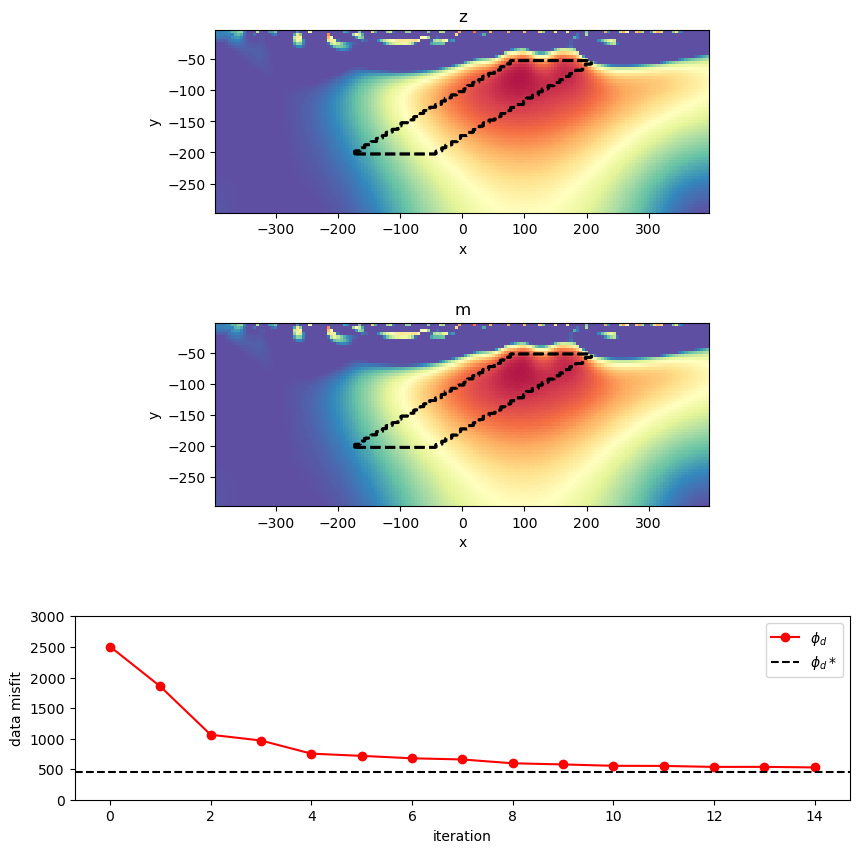

In [32]:
# phi_d = []
# errors = []
# u = np.zeros_like(mtrue[actcore])

# ii = 0
# for ii in range(15):
    
#     m = np.load(f'../model_{ii}.npy')
#     z = np.load(f'../z_variabe_{ii}.npy')
#     u += m - z
#     phi_d += [dmis(m)]
#     errors += [np.linalg.norm(u)]
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
meshCore.plot_image(1/ np.exp(z), ax=ax[0], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(m), ax=ax[1], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_title('z')
ax[1].set_title('m')
# ax[2].hist(m - z, 100)
# ax[2].set_title('contraint (m - z = 0)')
# ax[2].hist(1/ np.exp(m), 100, label='z', alpha=0.4)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
ax[2].plot(phi_d, '-or', label=r'$\phi_d$')
ax[2].axhline(dc_data.dobs.shape[0] / 2, color='k', linestyle='--', label=r'$\phi_d*$')
ax[2].set_ylim([0, 3000])
ax[2].legend()
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('data misfit')
plt.subplots_adjust(hspace=0.6, wspace=0.5)
plt.show()

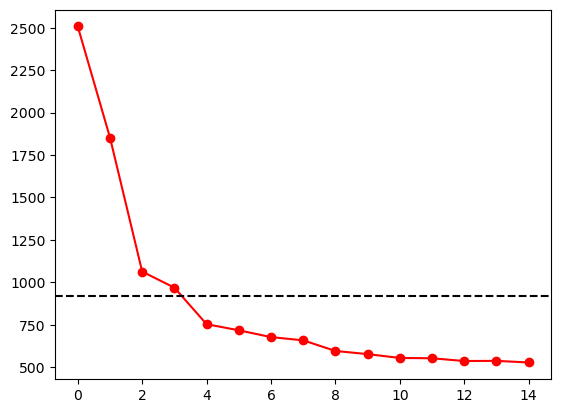

In [20]:
plt.plot(phi_d, '-or')
plt.axhline(dc_data.dobs.shape[0], color='k', linestyle='--')

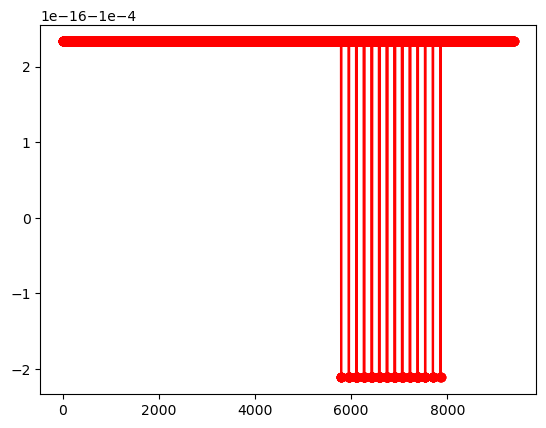

In [8]:
plt.plot(u, '-or')
# plt.axhline(dc_data.dobs.shape[0], color='k', linestyle='--')